# Imports

In [15]:
import itertools
import re

import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

import spacy
import xgboost as xgb

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib.pyplot as plt     

In [14]:
import mlflow

In [6]:
filepath = '../raw/disaster_tweets.csv'

In [7]:
df_raw = pd.read_csv(filepath)

# Pandas Profiling

In [8]:
profile = ProfileReport(df_raw, title='Twitter Disaster', explorative=True)

In [9]:
# profile.to_file("your_report.html")

# Variables

In [18]:
test_size = 0.2

In [10]:
df_raw.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

# Functions

In [11]:
def cm_viz(cm, name):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='d'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix: ' + name)
    plt.show();

In [16]:
def mlflow_run(features, algorithm, y_pred):

    with mlflow.start_run() as run:
        mlflow.log_param("feature space", features)
        mlflow.log_param("algorithm", algorithm)
        
        result = f1_score(y_train, y_pred)
        
        mlflow.log_metric("f1 score", result)
        
        mlflow.end_run()

# Split & Clean

In [17]:
X = df_raw.drop('target', axis=1)
y = df_raw['target']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, stratify=y)

In [21]:
X_train.shape, y_train.shape

((6090, 4), (6090,))

In [22]:
# drop ids, unnecessary
X_train = X_train.drop('id', axis=1)

In [23]:
# string cleaning
X_train['text'] = X_train['text'].str.lower()

In [24]:
# a few rows have no keywords
X_train = X_train.dropna(subset=['keyword'])

In [26]:
y_train = y_train.loc[X_train.index]

In [27]:
X_train_dummies = pd.get_dummies(X_train['keyword'])

# ML

##  URL

In [29]:
# urls
# source
link_regex = re.compile('(?P<url>https?://[^\s]+|$)')

<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
<ipython-input-29-ac29592419c5>:3: DeprecationWarning: invalid escape sequence \s
  link_regex = re.compile('(?P<url>https?://[^\s]+|$)')


In [30]:
X_train_url = X_train.copy()

In [31]:
X_train_url['url'] = X_train['text'].apply(lambda text: re.findall(link_regex, text)[0])

In [32]:
X_train_url['url_bool'] = ~X_train_url['url'].replace('', np.nan).isna()

In [33]:
cm = confusion_matrix(y_train, X_train_url['url_bool'])

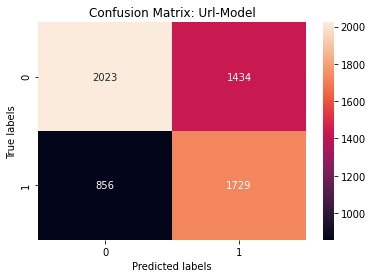

In [34]:
cm_viz(cm, 'Url-Model')

In [35]:
mlflow_run('Boolean URLs', 'NA', X_train_url['url_bool'])

## Keyword-Model

In [36]:
clf_keyword = LogisticRegression()

/home/yasin/miniconda3/envs/aida/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
cross_val_score(clf_keyword, X_train_dummies, y_train, cv=5, scoring='f1').mean()

0.6587041777084286

In [38]:
y_pred_keyword = cross_val_predict(clf_keyword, X_train_dummies, y_train, cv=5)

/home/yasin/miniconda3/envs/aida/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
cm = confusion_matrix(y_train, y_pred_keyword)

/home/yasin/miniconda3/envs/aida/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


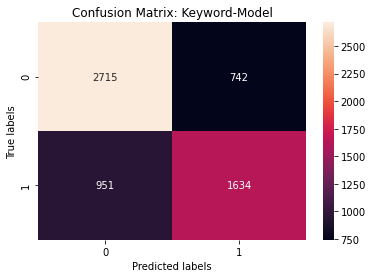

In [40]:
cm_viz(cm, 'Keyword-Model')

In [46]:
mlflow_run('OHE Keywords', clf_keyword.__class__.__name__, y_pred_keyword)

## TFIDF-Model

In [48]:
nlp = spacy.load("en_core_web_sm")

In [49]:
X_train_tfidf = X_train.copy()

In [50]:
X_train_tfidf['lemmatized'] = X_train['text'].apply(lambda text: " ".join([w.lemma_ for w in nlp(text)]))

In [51]:
vectorizer = TfidfVectorizer()

In [52]:
X_train_corpus = vectorizer.fit_transform(X_train_tfidf['lemmatized'])

In [53]:
clf_corpus = LogisticRegression()

In [54]:
cross_val_score(clf_corpus, X_train_corpus, y_train, cv=5, scoring='f1').mean()

0.7341370821922883

In [55]:
y_pred_corpus = cross_val_predict(clf_corpus, X_train_corpus, y_train, cv=5)

/home/yasin/miniconda3/envs/aida/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
cm = confusion_matrix(y_train, y_pred_corpus)

/home/yasin/miniconda3/envs/aida/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


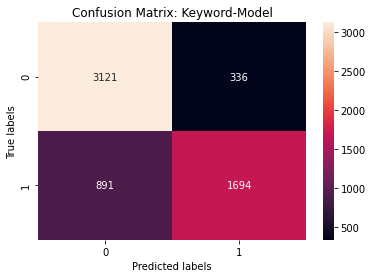

In [57]:
cm_viz(cm, 'Keyword-Model')

In [58]:
mlflow_run('TF-IDF', clf_corpus.__class__.__name__, y_pred_corpus)

## Tweet Length & Word Count

In [59]:
X_train_meta = pd.DataFrame(data=X_train['text'].str.len().values, columns=['length'], index=X_train.index)

In [60]:
X_train_meta['count'] = X_train['text'].str.split(' ').apply(lambda shape: len(shape))

In [61]:
clf_meta = LogisticRegression()

In [62]:
cross_val_score(clf_meta, X_train_meta, y_train, cv=5, scoring='f1').mean()

0.4816963730699362

In [63]:
y_pred_meta = cross_val_predict(clf_meta, X_train_meta, y_train, cv=5)

/home/yasin/miniconda3/envs/aida/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
cm = confusion_matrix(y_train, y_pred_meta)

/home/yasin/miniconda3/envs/aida/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


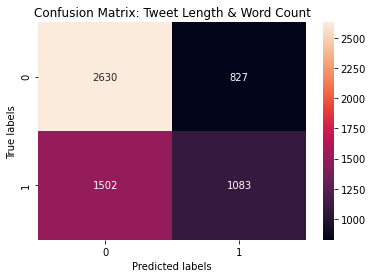

In [66]:
cm_viz(cm, 'Tweet Length & Word Count')

In [67]:
mlflow_run('Tweet Length & Word Count', clf_meta.__class__.__name__, y_pred_meta)

# Meta-Model & Feature combinations

## Feature combinations

In [68]:
df_stacking = pd.DataFrame(index=X_train.index)
df_stacking['keyword'] = y_pred_keyword
df_stacking['corpus'] = y_pred_corpus
df_stacking['meta'] = y_pred_meta
df_stacking['url'] = X_train_url['url_bool']

df_stacking = df_stacking.astype('bool')

In [69]:
combinations_raw = []

for i in range(len(df_stacking.columns)):
    i += 1
    combinations_raw.append(list(itertools.combinations(df_stacking.columns, i)))

In [70]:
combinations = [list(item) for sublist in combinations_raw for item in sublist]
combinations

/home/yasin/miniconda3/envs/aida/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


[['keyword'],
 ['corpus'],
 ['meta'],
 ['url'],
 ['keyword', 'corpus'],
 ['keyword', 'meta'],
 ['keyword', 'url'],
 ['corpus', 'meta'],
 ['corpus', 'url'],
 ['meta', 'url'],
 ['keyword', 'corpus', 'meta'],
 ['keyword', 'corpus', 'url'],
 ['keyword', 'meta', 'url'],
 ['corpus', 'meta', 'url'],
 ['keyword', 'corpus', 'meta', 'url']]

In [71]:
clf_stacking = RandomForestClassifier()

In [72]:
scores = {}
for combination in combinations:
    scores[str(combination)] = cross_val_score(clf_stacking, df_stacking[combination], y_train, cv=5, scoring='f1').mean()

In [73]:
df_scores = pd.DataFrame.from_dict(scores, orient='index', columns=['score'])
df_scores.sort_values('score', ascending=False)

/home/yasin/miniconda3/envs/aida/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,score
"['keyword', 'corpus', 'meta', 'url']",0.738770
['corpus'],0.734137
"['keyword', 'corpus']",0.734137
"['corpus', 'meta']",0.734137
"['corpus', 'url']",0.734137
"['keyword', 'corpus', 'meta']",0.734137
"['keyword', 'corpus', 'url']",0.734137
"['corpus', 'meta', 'url']",0.734137
['keyword'],0.658704
"['keyword', 'meta']",0.658704


In [74]:
df_stacking['target'] = y_train
df_stacking.corr()

/home/yasin/miniconda3/envs/aida/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,keyword,corpus,meta,url,target
keyword,1.000000,0.473961,0.151501,0.173780,0.422851
corpus,0.473961,1.000000,0.257947,0.377658,0.584633
meta,0.151501,0.257947,1.000000,0.495413,0.191252
url,0.173780,0.377658,0.495413,1.000000,0.251667
target,0.422851,0.584633,0.191252,0.251667,1.000000


## XGBoost

In [75]:
xgb_model = xgb.XGBClassifier()

/home/yasin/miniconda3/envs/aida/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.04, 0.05, 0.06], #so called `eta` value
              'max_depth': [6, 7, 8],
              'min_child_weight': [11],
              'subsample': [0.8],
              'n_estimators': [750, 1000, 1250]
              }

In [77]:
clf_xgb = GridSearchCV(xgb_model, parameters, scoring='f1')

In [79]:
clf_xgb.fit(df_stacking.drop('target', axis=1), df_stacking['target'])

/home/yasin/miniconda3/envs/aida/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [80]:
clf_xgb.best_estimator_

/home/yasin/miniconda3/envs/aida/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.04, max_delta_step=0, max_depth=6,
              min_child_weight=11, missing=nan, monotone_constraints='()',
              n_estimators=750, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [81]:
clf_xgb.best_score_

0.7387695641592671

In [91]:
y_pred_xgb = cross_val_predict(clf_xgb.best_estimator_, \
                               df_stacking.drop('target', axis=1), \
                               df_stacking['target'], \
                               cv=5)

In [92]:
cm = confusion_matrix(df_stacking['target'], y_pred_xgb)

/home/yasin/miniconda3/envs/aida/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


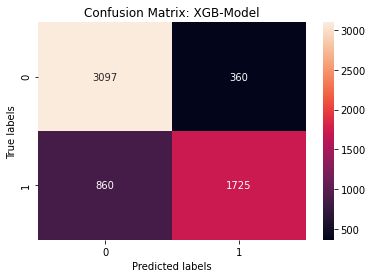

In [93]:
cm_viz(cm, 'XGB-Model')

XGBoost works better as a meta model rather than using the original TF-IDF feature space (0.73 vs. 0.63).

In [94]:
mlflow_run('Stacked Features', clf_xgb.best_estimator_.__class__.__name__, y_pred_xgb)